### Reference-based Annotation

#### Training

##### data info:
train data shape: (28154, 3000)
eval data shape: (4022, 3000)

In [1]:
import os
os.chdir('/home/share/huadjyin/home/s_huluni/project/bio_tools/CATree/case/Fig2_Tree')

In [2]:
import sys
sys.path.insert(0, "/home/share/huadjyin/home/s_huluni/project/bio_tools/CATree")

In [3]:
from catree.dataset.scDataset import scDataset
from catree.trainer.catree_trainer_v1 import CatreeTrainer
import pickle

prefix = "mmu_bone_marrow"
train_data_path = os.path.join(f"runs/data/{prefix}_train.h5ad")

sc_train = scDataset(adata=None,
                     data_path=train_data_path,
                     cell_type_key="cell_type_ontology_term_id",
                     trained=True,
                     highly_variable_genes=3000)

input_dim = sc_train.adata.shape[1]
print(input_dim)
device = "cuda"
ddp_train = False
ckpt_dir = os.path.join("models", "demo")
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

with open(os.path.join(ckpt_dir, 'gene_names.pk'), 'wb') as w1:
    pickle.dump(sc_train.adata.var_names, w1)
sc_train.ontograph.pickle(ckpt_dir)

trainer = CatreeTrainer(
    sc_train,
    input_type="expr",
    input_dim=input_dim,
    output_dim=64, # 
    batch_size=512, #
    learning_rate=0.01, #
    num_epochs=30, #
    beta=0.1, #
    device=device,
    global_layer=128, #
    local_layer=64, #
    hidden_layer_dropout=0.1, #
    ckpt_dir=ckpt_dir)

eval_data_path = os.path.join(f"runs/data/{prefix}_eval.h5ad")
sc_eval = scDataset(adata=None,
                    data_path=eval_data_path,
                    cell_type_key="cell_type_ontology_term_id",
                    trained=False,
                    highly_variable_genes=False)
sc_eval.adata = sc_eval.adata[:, sc_train.adata.var_names]
sc_eval.ontograph = sc_train.ontograph
sc_eval.cell_type_index = sc_eval.get_cell_type_index()

import time
import subprocess
import psutil

def get_gpu_usage():
    result = subprocess.run(['nvidia-smi', '--query-gpu=memory.used', '--format=csv,noheader'],
                            stdout=subprocess.PIPE, text=True)
    return int(result.stdout.strip().split()[0])  

def get_cpu_usage():
    return psutil.cpu_percent(interval=1) 

start_time = time.time()
initial_gpu_usage = get_gpu_usage()
max_gpu_usage = initial_gpu_usage
initial_cpu_usage = get_cpu_usage()

trainer.train(scdata_test=sc_eval)

end_time = time.time()
elapsed_time = end_time - start_time

final_gpu_usage = get_gpu_usage()
max_gpu_usage = max(max_gpu_usage, final_gpu_usage)
final_cpu_usage = get_cpu_usage()

print(f"Elapsed time: {elapsed_time:.2f} seconds")
print(f"Initial GPU usage: {initial_gpu_usage} MB")
print(f"Final GPU usage: {final_gpu_usage} MB")
print(f"Max GPU usage during training: {max_gpu_usage} MB")
print(f"Initial CPU usage: {initial_cpu_usage}%")
print(f"Final CPU usage: {final_cpu_usage}%")

Normalizing Data!
Transforming Data to Log1P!


/home/share/huadjyin/home/s_huluni/anaconda3/envs/py39_torch/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]


Graph loaded
{'CL:0000000'}
Lowest Common Ancestor: CL:0000000


100%|██████████| 18/18 [00:00<00:00, 1073.92it/s]


get id mapper ...
convert to vocab ...
get hierarchical levels ...
get hierarchical array...
get cell type idx set ...
1983
num_classes 10
[1, 4, 6, 9, 6, 5, 4, 4, 2, 1]
=== Initial Settings ===
Local Rank: 0
DDP Training: False
Checkpoint Directory: models/demo
Input Type: expr
Input Dimensions: 1983
Output Dimensions: 64
Batch Size: 512
Learning Rate: 0.01
Number of Epochs: 30
Beta: 0.1
Device: cuda
Global Layer: 128
Local Layer: 64
Hidden Layer Dropout: 0.1
LLM Model File: None
LLM Vocab File: None
LLM Args File: None
Number of Classes: 10
Label Dictionary: {'CL:0000576': 0, 'CL:0000094': 1, 'CL:0000235': 2, 'CL:0002191': 3, 'CL:0000050': 4, 'CL:0000765': 5, 'CL:0008001': 6, 'CL:0000547': 7, 'CL:0000623': 8, 'CL:0000816': 9, 'CL:0000817': 10, 'CL:0000898': 11, 'CL:0000559': 12, 'CL:0001066': 13, 'CL:0000786': 14, 'CL:0002048': 15, 'CL:0000788': 16, 'CL:0000767': 17}
Normalizing Data!
Transforming Data to Log1P!
Epoch [1/30]/11.39s,  Train Loss: 2.252513, eval_Acc: 0.2762, macro_f1: 

#### Predictions

##### data info:
test data shape: (8044, 3000)

In [4]:
from catree.task.anno_predict import catree_predict
device = "cuda:2"
prefix = "mmu_bone_marrow"
test_data_path = os.path.join(f"runs/data/{prefix}_test.h5ad")
ckpt_dir = os.path.join("models", "demo")

import time
import subprocess
import psutil

def get_gpu_usage():
    result = subprocess.run(['nvidia-smi', '--query-gpu=memory.used', '--format=csv,noheader'],
                            stdout=subprocess.PIPE, text=True)
    return int(result.stdout.strip().split()[0])  

def get_cpu_usage():
    return psutil.cpu_percent(interval=1) 

start_time = time.time()
initial_gpu_usage = get_gpu_usage()
max_gpu_usage = initial_gpu_usage
initial_cpu_usage = get_cpu_usage()

sc_dataset = catree_predict(
    adata=None,
    filepath=test_data_path,
    ckpt_dir=ckpt_dir,
    device=device)

end_time = time.time()
elapsed_time = end_time - start_time

final_gpu_usage = get_gpu_usage()
max_gpu_usage = max(max_gpu_usage, final_gpu_usage)
final_cpu_usage = get_cpu_usage()

print(f"Elapsed time: {elapsed_time:.2f} seconds")
print(f"Initial GPU usage: {initial_gpu_usage} MB")
print(f"Final GPU usage: {final_gpu_usage} MB")
print(f"Max GPU usage during training: {max_gpu_usage} MB")
print(f"Initial CPU usage: {initial_cpu_usage}%")
print(f"Final CPU usage: {final_cpu_usage}%")

from catree.utils.utils import compute_metrics

eval_metrics = compute_metrics(sc_dataset.adata.obs['cell_type_ontology_term_id'],
                               sc_dataset.adata.obs["predicted_cell_type_ontology_id"])
print("CATree eval, ", eval_metrics)

Normalizing Data!
Transforming Data to Log1P!
models/demo/ontoGraph.pk
useful gene index: 1983
View of AnnData object with n_obs × n_vars = 8044 × 1983
    obs: 'age', 'cell', 'free_annotation', 'method', 'donor_id', 'n_genes', 'subtissue', 'n_counts', 'louvain', 'leiden', 'assay_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'n_cells', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length'
    uns: 'citation', 'leiden', 'louvain', 'neighbors', 'pca', 'schema_reference', 'schema_version', 'title', 'log1p'


In [6]:
sc_dataset.ontograph.id2name

{'CL:0000945': 'lymphocyte of B lineage',
 'CL:0000145': 'professional antigen presenting cell',
 'CL:0000559': 'promonocyte',
 'CL:0000576': 'monocyte',
 'CL:0000988': 'hematopoietic cell',
 'CL:0000623': 'natural killer cell',
 'CL:0011026': 'progenitor cell',
 'CL:0000898': 'naive T cell',
 'CL:0000765': 'erythroblast',
 'CL:0000767': 'basophil',
 'CL:0000785': 'mature B cell',
 'CL:0002048': 'late pro-B cell',
 'CL:0008001': 'hematopoietic precursor cell',
 'CL:0001066': 'erythroid progenitor cell, mammalian',
 'CL:0001065': 'innate lymphoid cell',
 'CL:0000038': 'erythroid progenitor cell',
 'CL:0000946': 'antibody secreting cell',
 'CL:0002242': 'nucleate cell',
 'CL:0000786': 'plasma cell',
 'CL:0011115': 'precursor cell',
 'CL:0000816': 'immature B cell',
 'CL:0000788': 'naive B cell',
 'CL:0000738': 'leukocyte',
 'CL:0002419': 'mature T cell',
 'CL:0000547': 'proerythroblast',
 'CL:0001201': 'B cell, CD19-positive',
 'CL:0000255': 'eukaryotic cell',
 'CL:0000842': 'mononuclear

In [7]:
import json
cell_file = '/home/share/huadjyin/home/s_huluni/fengboyu/GANBO/catree/dataset/cell_type.json'
with open (cell_file,'w') as f:
    json.dump(sc_dataset.ontograph.id2name, f)

#### Visualization

In [5]:
adata_test = sc_dataset.adata.copy()

In [6]:
adata_test.shape

(8044, 1983)

In [7]:
import scanpy as sc
adata = sc.read_h5ad('/home/share/huadjyin/home/s_huluni/fengboyu/dataset/catree_data.h5ad')

In [4]:
adata.write_h5ad('/home/share/huadjyin/home/s_huluni/fengboyu/GANBO/catree/dataset/catree_data.h5ad')

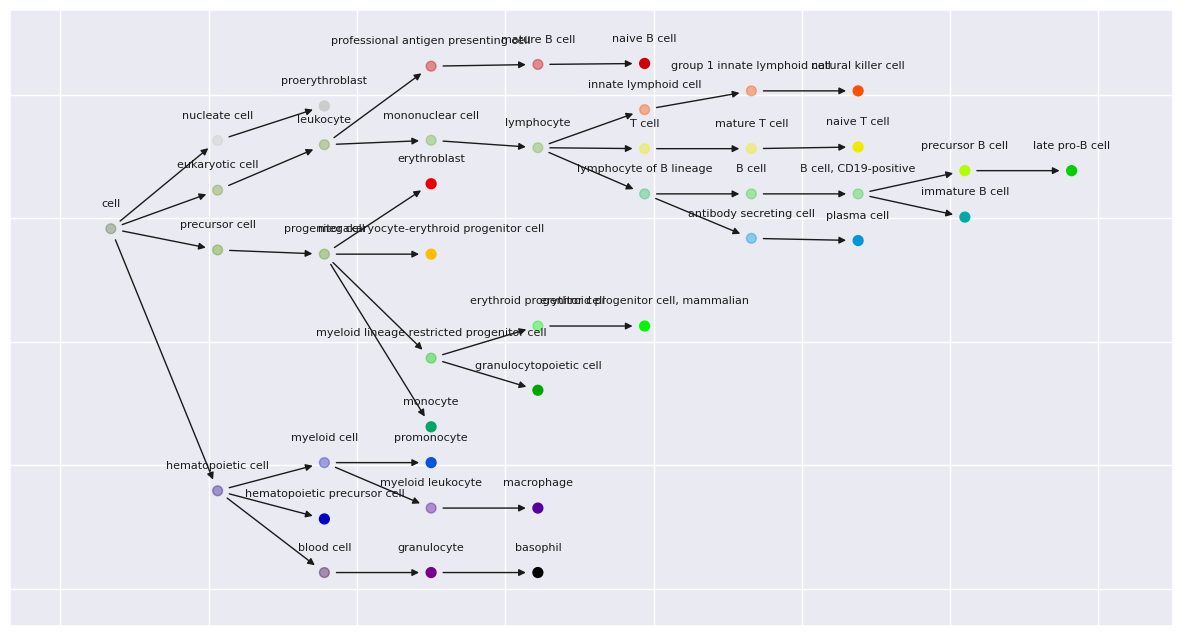

In [7]:
import json

level_keys = [key for key in adata_test.obs.columns if "level" in key]
import pandas as pd

sankey_df = pd.concat([adata_test.obs.groupby(["level_" + str(i - 1), "level_" + str(i)]).size().reset_index().rename(
    columns={"level_" + str(i - 1): "source", "level_" + str(i): "target", 0: "value"}) for i in
                       range(1, len(level_keys))], axis=0, ignore_index
                      =True)
sankey_df = sankey_df.loc[~sankey_df["value"].isin([0])].reset_index()

import networkx as nx

onto = sc_dataset.ontograph
G = onto.graph

tree = nx.nx_agraph.to_agraph(G)

# Layout the graph using dot layout
tree.layout(prog='dot')

# Get the node positions
node_positions = {}
for node in tree.nodes():
    node_name = node.get_name()
    x, y = node.attr['pos'].split(',')
    node_positions[node_name] = (float(x), float(y))
file = '/home/share/huadjyin/home/s_huluni/fengboyu/GANBO/catree/dataset/node_positions.json'
with open(file, "w") as f:
    json.dump(node_positions, f)
import pickle

with open(os.path.join(ckpt_dir, 'celltype_dict.pk'), 'rb') as f:
    label_dict = pickle.load(f)
leaf_nodes = {k: sum(v) for k, v in node_positions.items() if k in label_dict.keys()}

sorted_values = sorted(set(leaf_nodes.values()))
leaf_nodes = {k: sorted_values.index(v) for k, v in leaf_nodes.items()}

import matplotlib.pyplot as plt

# Choose a colormap
cmap = plt.cm.nipy_spectral

# Normalize the data to the range [0, 1]
norm = plt.Normalize(min(leaf_nodes.values()), max(leaf_nodes.values()))

# Create the color mapping dictionary
color_mapping = {k: cmap(norm(v)) for k, v in leaf_nodes.items()}
sorted_values = sorted(set(leaf_nodes.values()))
new_leaf_nodes = {k: sorted_values.index(v) for k, v in leaf_nodes.items()}

root_leafs = {node: nx.descendants(G, node).intersection(set(leaf_nodes.keys())) for node in G.nodes if
              node not in leaf_nodes.keys()}


def mix_colors(colors, weights=None):
    """
    Mix multiple colors with given weights.
    
    Parameters:
    colors (list): List of RGB color tuples (0-1 range).
    weights (list): List of corresponding weights for each color (0-1 range).
    
    Returns:
    tuple: The mixed RGB color (0-1 range).
    """
    if weights is None:
        weights = [1 / len(colors)] * len(colors)

    mixed_color = [0, 0, 0, 1]
    for i, color in enumerate(colors):
        mixed_color[0] += color[0] * weights[i]
        mixed_color[1] += color[1] * weights[i]
        mixed_color[2] += color[2] * weights[i]

    return tuple(mixed_color)


node_colors = {k: mix_colors([color_mapping[node] for node in v]) for k, v in root_leafs.items()}

node_colors.update(color_mapping)


def rgba_to_hex(rgba):
    """
    Convert an RGBA tuple (0-1 range) to a hexadecimal color code.
    
    Parameters:
    rgba (tuple): A tuple of four floats representing the RGBA values (0-1 range).
    
    Returns:
    str: The hexadecimal color code in the format '#RRGGBBAA'.
    """
    r, g, b, a = [round(x * 255) for x in rgba]
    return '#%02x%02x%02x%02x' % (r, g, b, a)


id2name = sc_dataset.ontograph.id2name
node_colors = {id2name[k]: rgba_to_hex(v) for k, v in node_colors.items()}
import networkx as nx

onto = sc_dataset.ontograph
G = onto.graph
G = nx.relabel_nodes(G, onto.id2name)
tree = nx.nx_agraph.to_agraph(G)

# Layout the graph using dot layout
tree.layout(prog='dot')

# Get the node positions
node_positions = {}
for node in tree.nodes():
    node_name = node.get_name()
    x, y = node.attr['pos'].split(',')
    node_positions[node_name] = (float(x), float(y))

import numpy as np
import math

theta = math.pi / 2
rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                            [np.sin(theta), np.cos(theta)]])

for node_name, (x, y) in node_positions.items():
    new_position = rotation_matrix @ np.array([x, y])
    node_positions[node_name] = (new_position[0], new_position[1])

label_positions = {k: (x, y + 100) for k, (x, y) in node_positions.items()}
node_alpha = [1 if node in set(adata_test.obs["cell_type"]) else 0.4 for node in G.nodes()]

plt.figure(figsize=(15, 8))
node_color = [node_colors[node] for node in G.nodes()]
nx.draw_networkx_nodes(G, node_positions, node_color=node_color, node_size=50, alpha=node_alpha)
nx.draw_networkx_edges(G, node_positions)
nx.draw_networkx_labels(G, label_positions, font_size=8)
plt.savefig("figs/mmu_bone_marrow_tree_graph.pdf")
plt.show()

In [12]:
list(G.edges)

[('granulocyte', 'basophil', 'is_a'),
 ('lymphocyte of B lineage', 'B cell', 'is_a'),
 ('lymphocyte of B lineage', 'antibody secreting cell', 'is_a'),
 ('lymphocyte', 'T cell', 'is_a'),
 ('lymphocyte', 'lymphocyte of B lineage', 'is_a'),
 ('lymphocyte', 'innate lymphoid cell', 'is_a'),
 ('antibody secreting cell', 'plasma cell', 'is_a'),
 ('progenitor cell', 'megakaryocyte-erythroid progenitor cell', 'is_a'),
 ('progenitor cell', 'monocyte', 'is_a'),
 ('progenitor cell', 'erythroblast', 'is_a'),
 ('progenitor cell', 'myeloid lineage restricted progenitor cell', 'is_a'),
 ('blood cell', 'granulocyte', 'is_a'),
 ('myeloid leukocyte', 'macrophage', 'is_a'),
 ('hematopoietic cell', 'blood cell', 'is_a'),
 ('hematopoietic cell', 'myeloid cell', 'is_a'),
 ('hematopoietic cell', 'hematopoietic precursor cell', 'is_a'),
 ('myeloid lineage restricted progenitor cell',
  'erythroid progenitor cell',
  'is_a'),
 ('myeloid lineage restricted progenitor cell',
  'granulocytopoietic cell',
  'is_a')

In [13]:
df = pd.DataFrame([edge[:2] for edge in G.edges], columns=['parents','subnodes'])

In [16]:
df.to_csv('/home/share/huadjyin/home/s_huluni/fengboyu/GANBO/catree/dataset/edge.csv',index=False)

In [6]:
adata_test.obs.head()

,age,cell,free_annotation,method,donor_id,n_genes,subtissue,n_counts,louvain,leiden,...,level_0,level_1,level_2,level_3,level_4,level_5,level_6,level_7,level_8,level_9
index,,,,,,,,,,,,,,,,,,,,,
10X_P7_2_ACGCAGCAGGGCACTA-1,3m,10X_P7_2_ACGCAGCAGGGCACTA,nan,droplet,3-F-56,3605,nan,19649.0,4,3,...,cell,hematopoietic cell,myeloid cell,promonocyte,NaN,NaN,NaN,NaN,NaN,NaN
TTTACTGCAGCTGGCT-1-72-0-0,24m,MACA_24m_M_BM_60_TTTACTGCAGCTGGCT,nan,droplet,24-M-60,661,nan,6643.0,21,26,...,cell,hematopoietic cell,blood cell,granulocyte,NaN,NaN,NaN,NaN,NaN,NaN
ACTATCTGTACCATCA-1-5-1-0,30m,10X_P1_5_ACTATCTGTACCATCA,nan,droplet,30-M-2,1398,BM (NON-STC),8244.0,19,18,...,cell,precursor cell,progenitor cell,myeloid lineage restricted progenitor cell,granulocytopoietic cell,NaN,NaN,NaN,NaN,NaN
TTTGGTTTCTCTGTCG-1-25-0-0,18m,MACA_18m_M_BM_52_TTTGGTTTCTCTGTCG,nan,droplet,18-M-52,2554,nan,12329.0,9,16,...,cell,hematopoietic cell,hematopoietic precursor cell,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TGTCCCAGTACAGTGG-1-73-0-0,24m,MACA_24m_M_BM_61_TGTCCCAGTACAGTGG,nan,droplet,24-M-61,610,nan,3129.0,2,0,...,cell,hematopoietic cell,blood cell,granulocyte,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
for level_key in adata_test.obs.columns:
    if "level" in level_key:
        adata_test.obs[level_key] = adata_test.obs[level_key].astype("category")
        adata_test.uns[level_key+"_colors"] = [node_colors.get(celltype) for celltype in adata_test.obs[level_key].cat.categories]

In [7]:
from pyecharts import options as opts
from pyecharts.charts import Sankey
import numpy as np

width='1000px'
height='600px'

node =[{'name':x, 'itemStyle': {'color': node_colors[x]}} for x in np.unique(list(sankey_df['source']) + list(sankey_df['target']))]
link = [x for x in sankey_df.T.to_dict().values()]
sankey = Sankey(
    init_opts=opts.InitOpts(
        theme='light',
        width=width,
        height=height,
    )
)

sankey.add(
    '',
    nodes=node,
    links=link,
    node_align='justify',
    #focus_node_adjacency=True,
    linestyle_opt=opts.LineStyleOpts(curve=0.5, opacity=0.2, color="source"),
    label_opts=opts.LabelOpts(position='right')
)

sankey.render('figs/mmu_bone_marrow_anno_sankey.html')

'/home/share/huadjyin/home/s_huluni/project/bio_tools/CATree/case/Fig2_Tree/figs/mmu_bone_marrow_anno_sankey.html'

/home/share/huadjyin/home/s_huluni/anaconda3/envs/py39_torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/share/huadjyin/home/s_huluni/anaconda3/envs/py39_torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


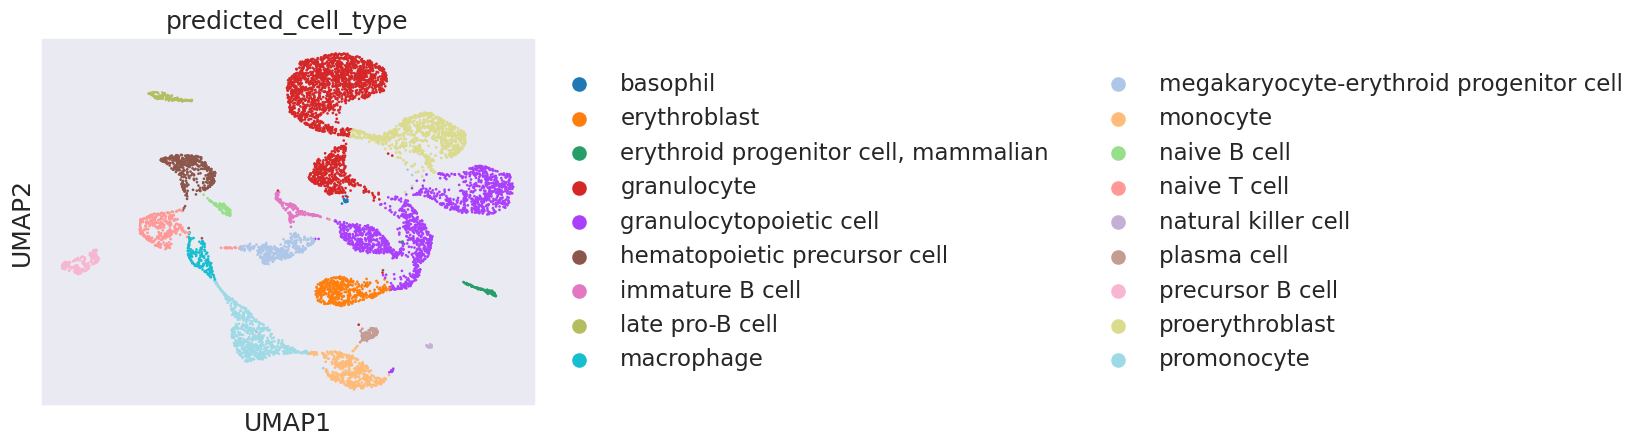

In [7]:
import scanpy as sc
sc.pp.neighbors(adata_test, use_rep="catree_emb")
sc.tl.umap(adata_test)
sc.pl.umap(adata_test, color="predicted_cell_type")

In [8]:
adata_test.obsm["X_umap"]

array([[  3.2524383 , -12.386378  ],
       [  9.517144  ,   7.5381193 ],
       [ 13.427912  ,  -3.9935565 ],
       ...,
       [  5.2466936 ,  -2.1922116 ],
       [  9.832053  ,   7.3633757 ],
       [ 12.184121  ,  -0.67505723]], dtype=float32)

/home/share/huadjyin/home/s_huluni/anaconda3/envs/py39_torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/share/huadjyin/home/s_huluni/anaconda3/envs/py39_torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/share/huadjyin/home/s_huluni/anaconda3/envs/py39_torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desire

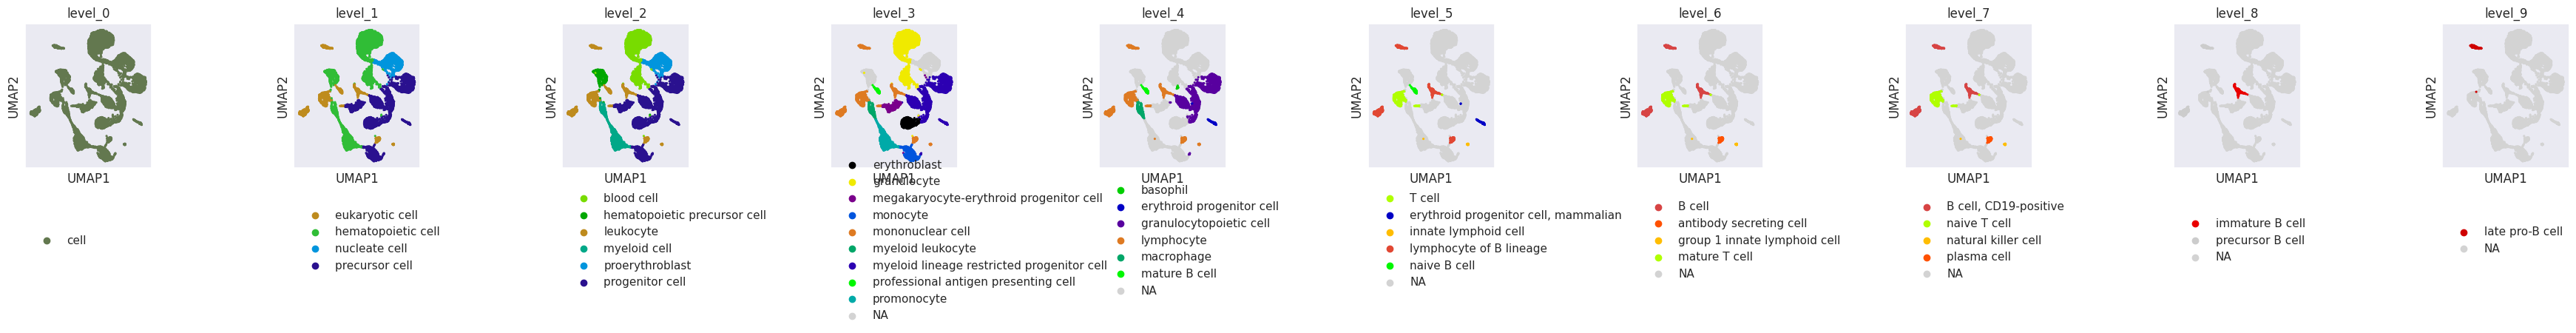

In [12]:
import matplotlib.pyplot as plt
import scanpy as sc

level_keys = [key for key in adata_test.obs.columns if "level" in key]
fig, axes = plt.subplots(ncols=len(level_keys), figsize=(len(level_keys)*3.5, 6))

for i, level_key in enumerate(level_keys):
    
    ax = axes[i]
    sc.pl.umap(adata_test, color=level_key, ax=ax, show=False, size=20)
    legend = ax.get_legend()
    if legend:
        legend.set_bbox_to_anchor((0, -.5), transform=ax.transAxes)
    ax.set_title(level_key)
    
plt.tight_layout()
plt.show()